![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/4.Clinical_DeIdentification.ipynb)


# Clinical Deidentification

## Colab Setup

In [ ]:
import json
import os

from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

In [ ]:
import json
import os

from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql import SparkSession

import sparknlp
import sparknlp_jsl

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
from sparknlp.util import *
from sparknlp.pretrained import ResourceDownloader
from pyspark.sql import functions as F

import pandas as pd

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

import string
import numpy as np

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(secret = SECRET, params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark

In [ ]:
# if you want to start the session with custom params as in start function above
from pyspark.sql import SparkSession

def start(SECRET):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "16G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:"+PUBLIC_VERSION) \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+SECRET+"/spark-nlp-jsl-"+JSL_VERSION+".jar")
      
    return builder.getOrCreate()

#spark = start(SECRET)

# Deidentification Model

Protected Health Information: 
- individual’s past, present, or future physical or mental health or condition
- provision of health care to the individual
- past, present, or future payment for the health care 

Protected health information includes many common identifiers (e.g., name, address, birth date, Social Security Number) when they can be associated with the health information.

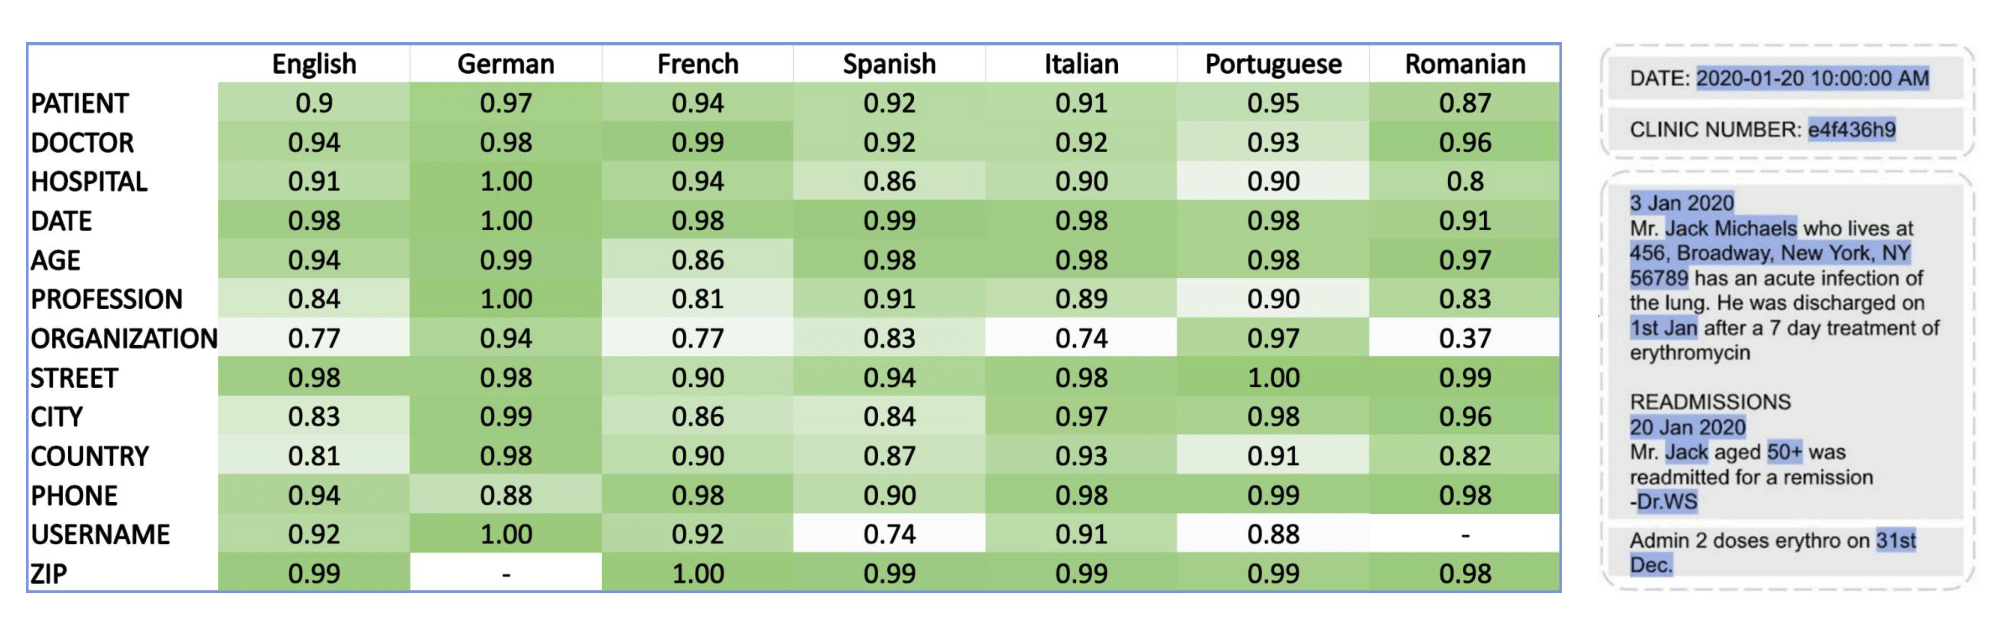

<center><b>Deidentification NER Models for English</b></center>

|index|model|lang|index|model|lang|index|model|lang|
|-----:|:-----|----|-----:|:-----|----|-----:|:-----|----|
| 1| [deidentify_dl](https://nlp.johnsnowlabs.com/2021/01/28/deidentify_dl_en.html)  |en| 7| [ner_deid_enriched_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_enriched_biobert_en.html)  |en| 13| [ner_deid_subentity_augmented](https://nlp.johnsnowlabs.com/2021/09/03/ner_deid_subentity_augmented_en.html)  |en|
| 2| [deidentify_large](https://nlp.johnsnowlabs.com/2020/08/04/deidentify_large_en.html)  |en| 8| [ner_deid_generic_augmented](https://nlp.johnsnowlabs.com/2021/06/30/ner_deid_generic_augmented_en.html)  |en| 14| [ner_deid_subentity_augmented_i2b2](https://nlp.johnsnowlabs.com/2021/11/29/ner_deid_subentity_augmented_i2b2_en.html)  |en|
| 3| [deidentify_rb](https://nlp.johnsnowlabs.com/2019/06/04/deidentify_rb_en.html)  |en| 9| [ner_deid_generic_glove](https://nlp.johnsnowlabs.com/2021/06/06/ner_deid_generic_glove_en.html)  |en| 15| [ner_deid_subentity_glove](https://nlp.johnsnowlabs.com/2021/06/06/ner_deid_subentity_glove_en.html)  |en|
| 4| [ner_deid_augmented](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_augmented_en.html)  |en| 10| [ner_deid_large](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_large_en.html)  |en| 16| [ner_deid_synthetic](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_synthetic_en.html)  |en|
| 5| [ner_deid_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_biobert_en.html)  |en| 11| [ner_deid_sd](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_sd_en.html)  |en| 17| [ner_deidentify_dl](https://nlp.johnsnowlabs.com/2021/03/31/ner_deidentify_dl_en.html)  |en|
| 6| [ner_deid_enriched](https://nlp.johnsnowlabs.com/2021/03/31/ner_deid_enriched_en.html)  |en| 12| [ner_deid_sd_large](https://nlp.johnsnowlabs.com/2021/04/01/ner_deid_sd_large_en.html)  |en| 18| []()|


<center><b>Deidentification NER Models for Other Languages</b></center>

|index|model|lang|index|model|lang|
|-----:|:-----|----|-----:|:-----|----|
| 1| [ner_deid_generic](https://nlp.johnsnowlabs.com/2022/01/06/ner_deid_generic_de.html)  |de| 11| [ner_deid_generic](https://nlp.johnsnowlabs.com/2022/02/11/ner_deid_generic_fr.html)  |fr|
| 2| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/01/06/ner_deid_subentity_de.html)  |de| 12| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/02/14/ner_deid_subentity_fr.html)  |fr|
| 3| [ner_deid_generic](https://nlp.johnsnowlabs.com/2022/01/18/ner_deid_generic_es.html)  |es| 13| [ner_deid_generic](https://nlp.johnsnowlabs.com/2022/03/25/ner_deid_generic_it_3_0.html)  |it|
| 4| [ner_deid_generic_augmented](https://nlp.johnsnowlabs.com/2022/02/16/ner_deid_generic_augmented_es.html)  |es| 14| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/03/25/ner_deid_subentity_it_2_4.html)  |it|
| 5| [ner_deid_generic_roberta](https://nlp.johnsnowlabs.com/2022/01/17/ner_deid_generic_roberta_es.html)  |es| 15| [ner_deid_generic](https://nlp.johnsnowlabs.com/2022/04/13/ner_deid_generic_pt_3_0.html)  |pt|
| 6| [ner_deid_generic_roberta_augmented](https://nlp.johnsnowlabs.com/2022/02/16/ner_deid_generic_roberta_augmented_es.html)  |es| 16| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/04/13/ner_deid_subentity_pt_3_0.html)  |pt|
| 7| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/01/18/ner_deid_subentity_es.html)  |es| 17| [ner_deid_subentity](https://nlp.johnsnowlabs.com/2022/06/27/ner_deid_subentity_ro_3_0.html)  |ro|
| 8| [ner_deid_subentity_augmented](https://nlp.johnsnowlabs.com/2022/02/16/ner_deid_subentity_augmented_es.html)  |es| 18| [ner_deid_subentity_bert](https://nlp.johnsnowlabs.com/2022/06/27/ner_deid_subentity_bert_ro_3_0.html)  |ro|
| 9| [ner_deid_subentity_roberta](https://nlp.johnsnowlabs.com/2022/01/17/ner_deid_subentity_roberta_es.html)  |es| 19| [ner_deid_generic](https://nlp.johnsnowlabs.com/models)  |ro|
| 10| [ner_deid_subentity_roberta_augmented](https://nlp.johnsnowlabs.com/2022/02/16/ner_deid_subentity_roberta_augmented_es.html)  |es| 20| [ner_deid_generic_bert](https://nlp.johnsnowlabs.com/models)  |ro|


You can find German, Spanish, French, Italian, Portuguese and Romanian deidentification models and pretrained pipeline examples in this notebook:   [Clinical Multi Language Deidentification Notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/4.1.Clinical_Multi_Language_Deidentification.ipynb)


**Let's start!**

Load NER pipeline to identify protected entities:

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line
sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

# NER model trained on n2c2 (de-identification and Heart Disease Risk Factors Challenge) datasets)
clinical_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")

nlpPipeline = Pipeline(stages=[
      documentAssembler, 
      sentenceDetector,
      tokenizer,
      word_embeddings,
      clinical_ner,
      ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)

### Pretrained NER models extracts:

- Name
- Profession
- Age
- Date
- Contact(Telephone numbers, FAX numbers, Email addresses)
- Location (Address, City, Postal code, Hospital Name, Employment information)
- Id (Social Security numbers, Medical record numbers, Internet protocol addresses)

In [ ]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 . PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital , 0295 Keats Street , Phone 55-555-5555 .
'''

In [ ]:
result = model.transform(spark.createDataFrame([[text]]).toDF("text"))

In [ ]:
result_df = result.select(F.explode(F.arrays_zip(result.token.result, 
                                                 result.ner.result)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("ner_label"))

In [ ]:
result_df.select("token", "ner_label").groupBy('ner_label').count().orderBy('count', ascending=False).show(truncate=False)

### Check extracted sensitive entities

In [ ]:
result.select(F.explode(F.arrays_zip(result.ner_chunk.result, 
                                     result.ner_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

### Excluding entities from deidentification

Sometimes we need to leave some entities in the text, for example, if we want to analyze the frequency of the disease by the hospital. In this case, we need to use parameter **`setWhiteList()`** to modify `ner_chunk` output. This parameter having using a list of entities type to deidentify as an input. So, if we want to leave the location in the list we need to remove this tag from the list:

In [ ]:
ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk") \
    .setWhiteList(['NAME', 'PROFESSION', 'ID', 'AGE', 'DATE'])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_with_white_list = nlpPipeline.fit(empty_data)

In [ ]:
result_with_white_list = model_with_white_list.transform(spark.createDataFrame([[text]]).toDF("text"))

In [ ]:
print("All Labels :")
result.select(F.explode(F.arrays_zip(result.ner_chunk.result, 
                                     result.ner_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

print("WhiteListed Labels: ")
result_with_white_list.select(F.explode(F.arrays_zip(result_with_white_list.ner_chunk.result, 
                                                     result_with_white_list.ner_chunk.metadata)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("chunk"),
                              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

## Masking and Obfuscation

### Replace these enitites with Tags

In [ ]:
ner_converter = NerConverterInternal()\
      .setInputCols(["sentence", "token", "ner"])\
      .setOutputCol("ner_chunk") 

deidentification = DeIdentification() \
      .setInputCols(["sentence", "token", "ner_chunk"]) \
      .setOutputCol("deidentified") \
      .setMode("mask")\
      .setReturnEntityMappings(True) #  return a new column to save the mappings between the mask/obfuscated entities and original entities.
      #.setMappingsColumn("MappingCol") # change the name of the column, 'aux' is default

deidPipeline = Pipeline(stages=[
      documentAssembler, 
      sentenceDetector,
      tokenizer,
      word_embeddings,
      clinical_ner,
      ner_converter,
      deidentification])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_deid = deidPipeline.fit(empty_data)

In [ ]:
result = model_deid.transform(spark.createDataFrame([[text]]).toDF("text"))

In [ ]:
result.show()

In [ ]:
result.select(F.explode(F.arrays_zip(result.sentence.result, result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

We have three modes to mask the entities in the Deidentification annotator. You can select the modes using the `.setMaskingPolicy()` parameter. The methods are the followings:

**“entity_labels”**: Mask with the entity type of that chunk. (default) <br/>
**“same_length_chars”**: Mask the deid entities with same length of asterix ( * ) with brackets ( [ , ] ) on both end. <br/>
**“fixed_length_chars”**: Mask the deid entities with a fixed length of asterix ( * ). The length is setting up using the `setFixedMaskLength()` method. <br/>
Let's try each of these and compare the results. 

In [ ]:
#deid model with "entity_labels"
deid_entity_labels= DeIdentification()\
    .setInputCols(["sentence", "token", "ner_chunk"])\
    .setOutputCol("deid_entity_label")\
    .setMode("mask")\
    .setReturnEntityMappings(True)\
    .setMaskingPolicy("entity_labels")

#deid model with "same_length_chars"
deid_same_length= DeIdentification()\
    .setInputCols(["sentence", "token", "ner_chunk"])\
    .setOutputCol("deid_same_length")\
    .setMode("mask")\
    .setReturnEntityMappings(True)\
    .setMaskingPolicy("same_length_chars")

#deid model with "fixed_length_chars"
deid_fixed_length= DeIdentification()\
    .setInputCols(["sentence", "token", "ner_chunk"])\
    .setOutputCol("deid_fixed_length")\
    .setMode("mask")\
    .setReturnEntityMappings(True)\
    .setMaskingPolicy("fixed_length_chars")\
    .setFixedMaskLength(4)


deidPipeline = Pipeline(stages=[
      documentAssembler, 
      sentenceDetector,
      tokenizer,
      word_embeddings,
      clinical_ner,
      ner_converter,
      deid_entity_labels,
      deid_same_length,
      deid_fixed_length])


empty_data = spark.createDataFrame([[""]]).toDF("text")
model_deid = deidPipeline.fit(empty_data)

In [ ]:
policy_result = model_deid.transform(spark.createDataFrame([[text]]).toDF("text"))

In [ ]:
policy_result.show()

In [ ]:
policy_result.select(F.explode(F.arrays_zip(policy_result.sentence.result, 
                                            policy_result.deid_entity_label.result, 
                                            policy_result.deid_same_length.result, 
                                            policy_result.deid_fixed_length.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("sentence"),
                     F.expr("cols['1']").alias("deid_entity_label"),
                     F.expr("cols['2']").alias("deid_same_length"),
                     F.expr("cols['3']").alias("deid_fixed_length")).toPandas()

### Mapping Column

In [ ]:
result.select("aux").show(truncate=False)

In [ ]:
result.select(F.explode(F.arrays_zip(result.aux.metadata, 
                                     result.aux.result, 
                                     result.aux.begin, 
                                     result.aux.end)).alias("cols")) \
      .select(F.expr("cols['0']['originalChunk']").alias("chunk"),
              F.expr("cols['0']['beginOriginalChunk']").alias("beginChunk"),
              F.expr("cols['0']['endOriginalChunk']").alias("endChunk"),
              F.expr("cols['1']").alias("label"),
              F.expr("cols['2']").alias("beginLabel"),
              F.expr("cols['3']").alias("endLabel")).show(truncate=False)

## Reidentification

We can use `ReIdentification` annotator to go back to the original sentence.

In [ ]:
reIdentification = ReIdentification()\
    .setInputCols(["aux","deidentified"])\
    .setOutputCol("original")

In [ ]:
reid_result = reIdentification.transform(result)

In [ ]:
reid_result.show()

In [ ]:
print(text)

reid_result.select('original.result').show(truncate=False)

## Using multiple NER in the same pipeline

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

deid_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_generic")

ner_converter = NerConverter()\
    .setInputCols(["sentence", "token", "ner_generic"])\
    .setOutputCol("ner_generic_chunk")\
    .setWhiteList(['ID', 'DATE', 'AGE', 'NAME', 'PROFESSION'])# CONTACT and LOCATION is removed

deid_ner_enriched = MedicalNerModel.pretrained("ner_deid_subentity_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_subentity")

ner_converter_enriched = NerConverter() \
    .setInputCols(["sentence", "token", "ner_subentity"]) \
    .setOutputCol("ner_subentity_chunk")\
    .setWhiteList(['COUNTRY', 'CITY', 'HOSPITAL', 'STATE', 'STREET', 'ZIP'])
    # we can also add PATIENT and DOCTOR entities and remove NAME entity from the other NER model

chunk_merge = ChunkMergeApproach()\
    .setInputCols("ner_subentity_chunk","ner_generic_chunk")\
    .setOutputCol("deid_merged_chunk")

deidentification = DeIdentification() \
    .setInputCols(["sentence", "token", "deid_merged_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("mask")\
    .setIgnoreRegex(True)


nlpPipeline = Pipeline(stages=[
      documentAssembler, 
      sentenceDetector,
      tokenizer,
      word_embeddings,
      deid_ner,
      ner_converter,
      deid_ner_enriched,
      ner_converter_enriched,
      chunk_merge,
      deidentification])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)

In [ ]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson Ora , MR # 7194334 Date : 01/13/93 . PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital , 0295 Keats Street , Phone 302-786-5227.
'''

In [ ]:
result = model.transform(spark.createDataFrame([[text]]).toDF("text"))

# ner_deid_generic_augmented
result.select(F.explode(F.arrays_zip(result.ner_generic_chunk.result, 
                                     result.ner_generic_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

In [ ]:
# ner_deid_subentity_augmented
result.select(F.explode(F.arrays_zip(result.ner_subentity_chunk.result, 
                                     result.ner_subentity_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

In [ ]:
# merged chunk
result.select(F.explode(F.arrays_zip(result.deid_merged_chunk.result, 
                                     result.deid_merged_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

In [ ]:
result.select(F.explode(F.arrays_zip(result.sentence.result, 
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"),
              F.expr("cols['1']").alias("deidentified")).toPandas()

### Enriching with Regex and Override NER




In [ ]:
# Text with MR number
text ='''Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson , Ora MR . # 7194334 Date : 01/13/93 PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital . 0295 Keats Street.'''

In [ ]:
deidentification = DeIdentification()\
    .setInputCols(["sentence", "token", "deid_merged_chunk"])\
    .setOutputCol("deidentified")\
    .setMode("mask") \
    .setRegexOverride(False) # Prioritizing NER model

pipeline = Pipeline(stages=[
    nlpPipeline, 
    deidentification
])

model_default_rgx = pipeline.fit(empty_data)

In [ ]:
result = model_default_rgx.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip(result.sentence.result, 
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

In [ ]:
# Creating regex rule for detecting MR number and AGE
rgx = '''NUMBER ([0-9]{2})
NUMBER (\d{7})''' 

with open("./custom_regex.txt", "w") as f:
  f.write(rgx)

f = open("./custom_regex.txt", "r")

print(f.read())

We see that two entities  have conflict between the regex and the NER. NER has the priority as default. We can change this `setRegexOverride` param 

In [ ]:
deidentification_rgx = DeIdentification()\
    .setInputCols(["sentence", "token", "deid_merged_chunk"])\
    .setOutputCol("deidentified")\
    .setMode("mask") \
    .setRegexPatternsDictionary("./custom_regex.txt")\
    .setRegexOverride(True) # Prioritizing regex rules

nlpPipeline_rgx = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    deid_ner,
    ner_converter,
    deid_ner_enriched,
    ner_converter_enriched,
    chunk_merge,
    deidentification_rgx])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_rgx = nlpPipeline_rgx.fit(empty_data)

In [ ]:
result = model_rgx.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip(result.sentence.result, 
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

`.setBlackList()` parameter so that not deidentifiy the labels that are specified in the list. This parameter filters just the detected Regex Entities.  

In [ ]:
ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")\
    .setWhiteList(["NAME", "LOCATION"])

# DATE, PHONE, URL, EMAIL, ZIP, DATE, SSN, PASSPORT, DLN, NPI, C_CARD, EMAIL, IBAN, DEA
deidentification = DeIdentification() \
    .setInputCols(["sentence", "token", "ner_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("mask")\
    .setRegexOverride(True)\
    .setBlackList(["DATE", "PHONE"]) # List of entities ignored for masking or obfuscation, default listed above

deidPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter,
    deidentification])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model_deid = deidPipeline.fit(empty_data)

In [ ]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson , Ora MR . # 7194334 Date : 01/13/93 PCP : Oliveira , 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital . 0295 Keats Street. Phone (302) 786-5227.
'''
result = model_deid.transform(spark.createDataFrame([[text]]).toDF("text"))

In [ ]:
result.select(F.explode(F.arrays_zip(result.sentence.result, 
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

## Obfuscation mode

In the obfuscation mode **DeIdentificationModel** will replace sensetive entities with random values of the same type. 


In [ ]:
obs_lines = """Marvin MARSHALL#PATIENT
Hubert GROGAN#PATIENT
ALTHEA COLBURN#PATIENT
Kalil AMIN#PATIENT
Inci FOUNTAIN#PATIENT
Ekaterina Rosa#DOCTOR
Rudiger Chao#DOCTOR
COLLETTE KOHLER#DOCTOR
Mufi HIGGS#DOCTOR"""


with open ('obfuscation.txt', 'w') as f:
  f.write(obs_lines)

In [ ]:
deid_ner_enriched = MedicalNerModel.pretrained("ner_deid_subentity_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_subentity")

ner_converter_enriched = NerConverter() \
    .setInputCols(["sentence", "token", "ner_subentity"]) \
    .setOutputCol("ner_subentity_chunk")\

obfuscation = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_subentity_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("obfuscate")\
    .setObfuscateDate(True)\
    #.setObfuscateRefFile('obfuscation.txt')\
    #.setObfuscateRefSource("both") #default: "faker"

pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    deid_ner_enriched,
    ner_converter_enriched,
    obfuscation
])

obfuscation_model = pipeline.fit(empty_data)

In [ ]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson , Ora MR # 7194334 Date : 01/13/93 . Patient : Oliveira, 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital . 0295 Keats Street
'''

result = obfuscation_model.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip(result.sentence.result, result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

In [ ]:
result.select("ner_subentity_chunk").collect()

In [ ]:
obfuscation = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_subentity_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("obfuscate")\
    .setObfuscateDate(True)\
    .setObfuscateRefFile('obfuscation.txt')\
    .setObfuscateRefSource("file")

pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    deid_ner_enriched,
    ner_converter_enriched,
    obfuscation
])

obfuscation_model = pipeline.fit(empty_data)      
      
      
result = obfuscation_model.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip(result.sentence.result, 
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

## Faker mode

The faker module allows the user to use a set of fake entities that are in the memory of spark-nlp-internal. You can set up this module using the following property: `setObfuscateRefSource('faker')`.

If we select the `setObfuscateRefSource('both')` then we choose randomly the entities using the faker and the fakes entities from the obfuscateRefFile.


The entities that are allowed right now are the followings:

* Location
* Location-other
* Hospital
* City
* State
* Zip
* Country
* Contact
* Username
* Phone
* Fax
* Url
* Email
* Profession
* Name
* Doctor
* Patient
* Id
* Idnum
* Bioid
* Age
* Organization
* Healthplan
* Medicalrecord
* Ssn
* Passport
* DLN
* NPI
* C_card
* IBAN
* DEA
* Device




In [ ]:
obfuscation = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_subentity_chunk"]) \
    .setOutputCol("deidentified") \
    .setMode("obfuscate")\
    .setObfuscateDate(True)\
    .setObfuscateRefSource("faker") \

pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    deid_ner_enriched,
    ner_converter_enriched,
    obfuscation
])

obfuscation_model = pipeline.fit(empty_data)

In [ ]:
text ='''
Record date : 2093-01-13 , David Hale , M.D . , Name : Hendrickson , Ora MR # 7194334 Date : 01/13/93 . Patient : Oliveira, 25 years-old , Record date : 2079-11-09 . Cocke County Baptist Hospital . 0295 Keats Street
'''

result = obfuscation_model.transform(spark.createDataFrame([[text]]).toDF("text"))

result.select(F.explode(F.arrays_zip(result.sentence.result,
                                     result.deidentified.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("sentence"), F.expr("cols['1']").alias("deidentified")).toPandas()

## Use full pipeline in the Light model

In [ ]:
light_model = LightPipeline(model)
annotated_text = light_model.annotate(text)
annotated_text['deidentified']

In [ ]:
obf_light_model = LightPipeline(obfuscation_model)
annotated_text = obf_light_model.annotate(text)
annotated_text['deidentified']

## Shifting Days

In the examples above, we replaced date entities with another date randomly. Instead of that, we can shift the date according to any column.

In [ ]:
data = pd.DataFrame(
    {'patientID' : ['A001', 'A001', 'A002', 'A002'],
     'text' : ['Chris Brown was discharged on 10/02/2022', 
               'Mark White was discharged on 02/28/2020', 
               'John was discharged on 03/15/2022',
               'John Moore was discharged on 12/31/2022'
              ]
    }
)

my_input_df = spark.createDataFrame(data)

my_input_df.show(truncate = False)

### Shifting days according to the ID column

We use the `DocumentHashCoder()` annotator to determine shifting days. This annotator gets the hash of the specified column and creates a new document column containing day shift information. And then, the `DeIdentification` annotator deidentifies this new doc. We should set the seed parameter to hash consistently.  

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

documentHasher = DocumentHashCoder()\
    .setInputCols("document")\
    .setOutputCol("document2")\
    .setPatientIdColumn("patientID")\
    .setRangeDays(100)\
    .setNewDateShift("shift_days")\
    .setSeed(100)

tokenizer = Tokenizer()\
    .setInputCols(["document2"])\
    .setOutputCol("token")

embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["document2", "token"])\
    .setOutputCol("word_embeddings")

clinical_ner = MedicalNerModel\
    .pretrained("ner_deid_subentity_augmented", "en", "clinical/models")\
    .setInputCols(["document2","token", "word_embeddings"])\
    .setOutputCol("ner")

ner_converter = NerConverter()\
    .setInputCols(["document2", "token", "ner"])\
    .setOutputCol("ner_chunk")

de_identification = DeIdentification() \
    .setInputCols(["ner_chunk", "token", "document2"]) \
    .setOutputCol("deid_text") \
    .setMode("obfuscate") \
    .setObfuscateDate(True) \
    .setDateTag("DATE") \
    .setLanguage("en") \
    .setObfuscateRefSource('faker') \
    .setUseShifDays(True)\
    .setRegion('us')
    

pipeline = Pipeline().setStages([
    documentAssembler,
    documentHasher,
    tokenizer,
    embeddings,
    clinical_ner,
    ner_converter,
    de_identification
    
])

empty_data = spark.createDataFrame([["", ""]]).toDF("text", "patientID")

pipeline_model = pipeline.fit(empty_data)

In [ ]:
output = pipeline_model.transform(my_input_df)

output.select('patientID','text', "shift_days", 'deid_text.result').show(truncate = False)

### Shifting days according to specified values

Instead of shifting days according to ID column, we can specify shifting values with another column.

```python
documentHasher = DocumentHashCoder()\
    .setInputCols("document")\
    .setOutputCol("document2")\
    .setDateShiftColumn("dateshift")\
```


In [ ]:
data = pd.DataFrame(
    {'patientID' : ['A001', 'A002', 'A003', 'A004'],
     'text' : ['Chris Brown was discharged on 10/02/2022', 
               'Mark White was discharged on 03/01/2020', 
               'John was discharged on 03/15/2022',
               'John Moore was discharged on 12/31/2022'
              ],
     'dateshift' : ['10', '-2', '30', '-8']
    }
)

my_input_df = spark.createDataFrame(data)

my_input_df.show(truncate=False)

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

documentHasher = DocumentHashCoder()\
    .setInputCols("document")\
    .setOutputCol("document2")\
    .setDateShiftColumn("dateshift")\

tokenizer = Tokenizer()\
    .setInputCols(["document2"])\
    .setOutputCol("token")

embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["document2", "token"])\
    .setOutputCol("word_embeddings")

clinical_ner = MedicalNerModel\
    .pretrained("ner_deid_subentity_augmented", "en", "clinical/models")\
    .setInputCols(["document2","token", "word_embeddings"])\
    .setOutputCol("ner")

ner_converter = NerConverter()\
    .setInputCols(["document2", "token", "ner"])\
    .setOutputCol("ner_chunk")

de_identification = DeIdentification() \
    .setInputCols(["ner_chunk", "token", "document2"]) \
    .setOutputCol("deid_text") \
    .setMode("obfuscate") \
    .setObfuscateDate(True) \
    .setDateTag("DATE") \
    .setLanguage("en") \
    .setObfuscateRefSource('faker') \
    .setUseShifDays(True)\
    .setRegion('us')

pipeline_col = Pipeline().setStages([
    documentAssembler,
    documentHasher,
    tokenizer,
    embeddings,
    clinical_ner,
    ner_converter,
    de_identification
    
])

empty_data = spark.createDataFrame([["", "", ""]]).toDF("patientID","text", "dateshift")

pipeline_col_model = pipeline_col.fit(empty_data)

In [ ]:
output = pipeline_col_model.transform(my_input_df)

output.select('text', 'dateshift', 'deid_text.result').show(truncate = False)

Here, dates were shifted according to `dateshift` column

### Masking Unnormalized Date Formats

`setUnnormalizedDateMode()` parameter is used to mask the DATE entities that can not be normalized. In the example below, please check `03Apr2022` which couldn't be normalized and it is masked in the output.

In [ ]:
data = pd.DataFrame(
    {'patientID' : ['A001', 'A001', 'A002', 'A002'],
     'text' : ['Chris Brown was discharged on 10/02/2022', 
               'Mark White was discharged on 02/28/2020', 
               'John was discharged on 03Apr2022',          # check this
               'John Moore was discharged on 12/31/2022'
              ],
     'dateshift' : ['10', '10', '30', '30']
    }
)

my_input_df = spark.createDataFrame(data)

de_identification = DeIdentification() \
    .setInputCols(["ner_chunk", "token", "document2"]) \
    .setOutputCol("deid_text") \
    .setMode("obfuscate") \
    .setObfuscateDate(True) \
    .setDateTag("DATE") \
    .setLanguage("en") \
    .setObfuscateRefSource('faker') \
    .setUseShifDays(True)\
    .setRegion('us')\
    .setUnnormalizedDateMode("mask")

pipeline = Pipeline().setStages([
    documentAssembler,
    documentHasher,
    tokenizer,
    embeddings,
    clinical_ner,
    ner_converter,
    de_identification
    
])


output = pipeline.fit(my_input_df).transform(my_input_df)

output.select('text', 'dateshift', 'deid_text.result').show(truncate = False)

# Not to Deidentify a Part of an Entity

Sometimes we may want not to deidentify some entities. For example, according to the HIPAA rules, we don't have to deidentify years. So lets show an example how we can skip the deidentification of an entity. 

Pretrained NER models deidentify years as `DATE`. So we will create a contextual parser for extracting `YEAR` entities only, and will merge its results with NER results by using `setBlackList` parameter.

You can check [ContextualParser Notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.2.Contextual_Parser_Rule_Based_NER.ipynb) to understand its logic better.

In [ ]:
year = {
  "entity": "YEAR",
  "ruleScope": "sentence",
  "matchScope":"token",
  "regex": "^[12][0-9]{3}$",
  "valuesDefinition":[],
#   "prefix": ["in"],
  "contextLength": 100,
  "context": []
}

with open('year.json', 'w') as f:
    json.dump(year, f)

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

year_contextual_parser = ContextualParserApproach() \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("entity_year") \
    .setJsonPath("year.json") \
    .setCaseSensitive(False) \
    .setPrefixAndSuffixMatch(False)

year_model = Pipeline(stages=[documentAssembler, sentenceDetector, tokenizer, year_contextual_parser]).fit(spark.createDataFrame([[""]]).toDF("text"))

sample_text = "Patient ID: 6515426. My brother was admitted to the hospital in 2005. I will go to spain in 2025. "

lyear = LightPipeline(year_model)
lyear.annotate(sample_text)

As you can see, 2005 and 2025 year entities are extracted as `YEAR`. 

You can define stronger contextual parser for detecting year entities by  setting a stronger regex rule or playing with the parameters of CP (like `prefix -> in`)

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

clinical_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_generic")

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_generic"])\
    .setOutputCol("ner_generic_chunk")

year_contextual_parser = ContextualParserApproach() \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("entity_year") \
    .setJsonPath("year.json") \
    .setCaseSensitive(False) \
    .setPrefixAndSuffixMatch(False)

chunks_year= ChunkConverter()\
    .setInputCols("entity_year")\
    .setOutputCol("chunk_year")

# First we will merge chunk_year and ner_generic_chunk
# chunk merger will give the precedence to year_chunk
# if they extract the same year entities. 
chunk_merge_1 = ChunkMergeApproach()\
    .setInputCols("chunk_year","ner_generic_chunk")\
    .setOutputCol("deid_merged_chunk")


deid_ner_enriched = MedicalNerModel.pretrained("ner_deid_subentity_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_subentity")

# we will block DATE entities coming from this model
# the dates will already been detected by ner_deid_generic_augmented
ner_converter_enriched = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_subentity"]) \
    .setOutputCol("ner_subentity_chunk")\
    .setBlackList(['DATE'])

# now we will merge ner_subentity_chunk with deid_merged_chunk
# and will block YEAR entities 
# in this way YEAR entities will not appear in the results
chunk_merge_2 = ChunkMergeApproach()\
    .setInputCols("deid_merged_chunk","ner_subentity_chunk")\
    .setOutputCol("final_merged_chunk")\
    .setBlackList(["YEAR"])

deid_entity_labels= DeIdentification()\
    .setInputCols(["sentence", "token", "final_merged_chunk"])\
    .setOutputCol("deid_entity_label")\
    .setMode("mask")\
    .setReturnEntityMappings(True)\
    .setMaskingPolicy("entity_labels")

nlpPipeline = Pipeline(stages=[
      documentAssembler, 
      sentenceDetector,
      tokenizer,
      word_embeddings,
      clinical_ner,
      ner_converter,
      year_contextual_parser,
      chunks_year,
      chunk_merge_1,
      deid_ner_enriched,
      ner_converter_enriched,
      chunk_merge_2,
      deid_entity_labels
      ])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = nlpPipeline.fit(empty_data)

We will use the sample text below, and we wait single YEAR entities (2008 and 2009) not to deidentify. But if there is months or days with year, they will be deidentified in any case.

In [ ]:
sample_text = """A 28 year old female with a history of gestational diabetes mellitus diagnosed eight years prior to 
presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis 
three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index 
( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting.
Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . 
She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . 
She had been on dapagliflozin since May 2006 . On 30 June 2007 , her physical examination on presentation was 
significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , 
or rigidity . In 2008 laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , 
anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin 
( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed 
as blood samples kept hemolyzing due to significant lipemia .
The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior 
to admission in 2009. However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , 
the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 950 mg/dL , 
and lipase was 52 U/L . She was discharged on 05 June 2012 . 

Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . 
At birth the typical boy is growing slightly faster than the typical girl, but the velocities become equal at about 
seven months, and then the girl grows faster until four years. 
From then until adolescence no differences in velocity 
can be detected. 21-02-2020 
21/04/2020
"""

In [ ]:
lmodel= LightPipeline(model)
lresult= lmodel.fullAnnotate(sample_text)[0]

In [ ]:
# YEAR chunks detected by CP

lresult["chunk_year"]

In [ ]:
# chunks are detected by ner_deid_generic_augmented

lresult["ner_generic_chunk"]

In [ ]:
# 2008 and 2009 entities are labelled as YEAR in merged chunk

lresult["deid_merged_chunk"]

In [ ]:
lresult["final_merged_chunk"]

`YEAR` entities were in `deid_merged_chunk`, but they are not in `final_merged_chunk`. 



In [ ]:
result_df = model.transform(spark.createDataFrame([[sample_text]]).toDF("text"))

In [ ]:
pd.set_option("display.max_colwidth",0)

pd_result = result_df.select(F.explode(F.arrays_zip(result_df.sentence.result, result_df.deid_entity_label.result)).alias("cols")) \
                     .select(F.expr("cols['0']").alias("sentence"),
                             F.expr("cols['1']").alias("deid_entity_label")).toPandas()

pd_result

When you check the 6th and 9th lines, you can see that the YEAR only entities are not deidentified.

# Structured Deidentification

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/hipaa-table-001.txt

df = spark.read.format("csv") \
    .option("sep", "\t") \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .load("hipaa-table-001.txt")

df = df.withColumnRenamed("PATIENT","NAME")
df.show(truncate=False)

In [ ]:
from sparknlp_jsl.structured_deidentification import StructuredDeidentification

In [ ]:
obfuscator = StructuredDeidentification(spark,{"NAME":"PATIENT","AGE":"AGE"}, obfuscateRefSource = "faker")
obfuscator_df = obfuscator.obfuscateColumns(df)
obfuscator_df.show(truncate=False)

In [ ]:
obfuscator_unique_ref_test = '''Will Perry#PATIENT
John Smith#PATIENT
Marvin MARSHALL#PATIENT
Hubert GROGAN#PATIENT
ALTHEA COLBURN#PATIENT
Kalil AMIN#PATIENT
Inci FOUNTAIN#PATIENT
Jackson WILLE#PATIENT
Jack SANTOS#PATIENT
Mahmood ALBURN#PATIENT
Marnie MELINGTON#PATIENT
Aysha GHAZI#PATIENT
Maryland CODER#PATIENT
Darene GEORGIOUS#PATIENT
Shelly WELLBECK#PATIENT
Min Kun JAE#PATIENT
Thomson THOMAS#PATIENT
Christian SUDDINBURG#PATIENT
Aberdeen#CITY
Louisburg St#STREET
France#LOC
Nick Riviera#DOCTOR
5552312#PHONE
St James Hospital#HOSPITAL
Calle del Libertador#ADDRESS
111#ID
Will#DOCTOR
20#AGE
30#AGE
40#AGE
50#AGE
60#AGE
'''

with open('obfuscator_unique_ref_test.txt', 'w') as f:
  f.write(obfuscator_unique_ref_test)

In [ ]:
# obfuscateRefSource = "file"

obfuscator = StructuredDeidentification(spark,{"NAME":"PATIENT","AGE":"AGE"}, 
                                        obfuscateRefFile = "/content/obfuscator_unique_ref_test.txt",
                                        obfuscateRefSource = "file",
                                        columnsSeed={"NAME": 23, "AGE": 23})
obfuscator_df = obfuscator.obfuscateColumns(df)
obfuscator_df.select("NAME","AGE").show(truncate=False)

We can **shift n days** in the structured deidentification through "days" parameter when the column is a Date.

In [ ]:
df = spark.createDataFrame([
            ["Juan García", "13/02/1977", "711 Nulla St.", "140", "673 431234"],
            ["Will Smith", "23/02/1977", "1 Green Avenue.", "140", "+23 (673) 431234"],
            ["Pedro Ximénez", "11/04/1900", "Calle del Libertador, 7", "100", "912 345623"]
        ]).toDF("NAME", "DOB", "ADDRESS", "SBP", "TEL")
df.show(truncate=False)

In [ ]:
obfuscator = StructuredDeidentification(spark=spark, 
                                        columns={"NAME": "ID", "DOB": "DATE"},
                                        columnsSeed={"NAME": 23, "DOB": 23},
                                        obfuscateRefSource="faker",
                                        days=5
                                         )

In [ ]:
result = obfuscator.obfuscateColumns(df)
result.show(truncate=False)

# Pretrained Deidentification Pipeline

`clinical_deidentification` pipeline can be used to deidentify PHI information from medical texts. The PHI information will be masked and obfuscated in the resulting text. The pipeline can mask and obfuscate `AGE`, `CONTACT`, `DATE`, `ID`, `LOCATION`, `NAME`, `PROFESSION`, `CITY`, `COUNTRY`, `DOCTOR`, `HOSPITAL`, `IDNUM`, `MEDICALRECORD`, `ORGANIZATION`, `PATIENT`, `PHONE`, `PROFESSION`, `STREET`, `USERNAME`, `ZIP`, `ACCOUNT`, `LICENSE`, `VIN`, `SSN`, `DLN`, `PLATE`, `IPADDR` entities. There is also a slim version of deidentificaiton pipeline, `clinical_deidentification_slim`

In [ ]:
from sparknlp.pretrained import PretrainedPipeline

deid_pipeline = PretrainedPipeline("clinical_deidentification", "en", "clinical/models")

In [ ]:
deid_pipeline.model.stages

In [ ]:
text= """Name : Hendrickson, Ora, Record date: 2093-01-13, Age: 25, # 719435. Dr. John Green, ID: 1231511863, IP 203.120.223.13. He is a 60-year-old male was admitted to the Day Hospital for cystectomy on 01/13/93. Patient's VIN : 1HGBH41JXMN109286, SSN #333-44-6666, Driver's license no:A334455B. Phone (302) 786-5227, 0295 Keats Street, San Francisco."""

In [ ]:
deid_res= deid_pipeline.annotate(text)

In [ ]:
deid_res.keys()

In [ ]:
pd.set_option("display.max_colwidth", 100)

df= pd.DataFrame(list(zip(deid_res["sentence"], 
                          deid_res["masked"],
                          deid_res["masked_with_chars"],
                          deid_res["masked_fixed_length_chars"], 
                          deid_res["obfuscated"])),
                 columns= ["Sentence", "Masked", "Masked with Chars", "Masked with Fixed Chars", "Obfuscated"])

df